In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random as rd

In [2]:
rd.seed(1)

In [3]:
def sharpe_ratio(returns_risky, keys, returns_risk_free):
    mean_risk_free = np.mean(np.mean(returns_risk_free, 0))
    ratio = {}
    for key in keys:
        mean_return_risky = np.mean(returns_risky[key])
        sigma_risky = np.var(returns_risky[key])
        ratio[key] = (mean_return_risky - mean_risk_free)/sigma_risky
    return ratio        

In [4]:
def calculate_transaction_costs(change_in_positions, cost_per_trade):
    return np.sum(np.abs(change_in_positions)) * cost_per_trade
def ret2price(ret):
    price = np.ones(len(ret))
    for i in range(1, len(ret)):
        price[i] = ret[i]*price[i-1]
    return price
def price2ret(price):
    ret = np.ones(len(price))
    for i in range(1, len(ret)):
        ret[i] = price[i]/price[i-1]
    return ret

In [5]:
Valori_Predetti = pd.read_excel('Valori_Predetti.xlsx', sheet_name = 'Test')
keys = Valori_Predetti.columns
Valori_Predetti = Valori_Predetti.drop(0)
result = {key: Valori_Predetti[key].tolist() for key in keys}
keys=[0.404] #Here we  consider only the key 0.404 that corresponds to the optimal treshold that we got before#

Now here we import just the test set to see how our model performs out of sample.

In [6]:
# Read data
data = pd.read_excel('InvestmentReplica2.xlsx', sheet_name='Test')
dates = data['Date'].values
data.drop(columns=['Date'], inplace=True)

# Target index
data['Target'] = 0.5 * data['HFRXGL'] + 0.25 * data['MXWO'] + 0.25 * data['LEGATRUU']

# Compute returns for all columns
returns = data.pct_change()+1
returns.drop(index=0, inplace=True)

# Features selection
features = returns.columns.drop(['HFRXGL', 'MXWO', 'LEGATRUU', 'MXWD','LLL1','Target','TP1','TY1','VG1','DU1', 'NQ1'])
target = 'Target'
X = returns[features].values
y = returns[target].values

Here we apply the Kalman filter with the selected threshold and with alpha=0, so we completely eliminate our exposure if we find some kind of anomaly.
After that we repeat the same procedure for different alphas to see how the algorithm would perform.

We believe that the choice for an optimal alpha is really a business oriented choice.

It may depend on the level of risk aversion of the investor or the firm.

Also a firm may decide to apply a different level for alpha for different clients to which they are selling their investment product.

Case 1: alpha = 0

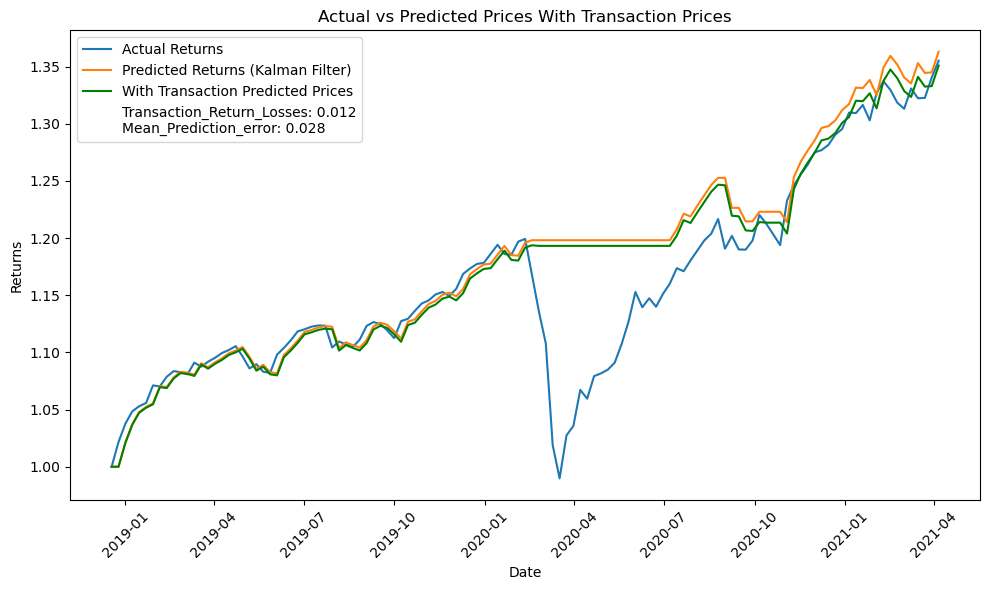

In [7]:
# Initialized vectors
y_test_kalman = []
y_pred_kalman = []
dates_plot_kalman = []

# Define parameters for Kalman filter
num_features = X.shape[1]
num_time_steps = len(y)

A = np.eye(num_features)
B = np.diag(np.diag(np.cov(X.T)))
C = np.eye(num_features)  # Inizializzazione di C(t)
D = np.std(y)

Q = np.cov(X, rowvar=False)
R = D**2

window_size = 104

portfolio_weights=[]
adjusted_portfolio_prices=[]

# Apply rolling window with Kalman filter
for i in range(window_size, len(returns) - 1):
    # Split the data into training and testing sets using rolling window
    X_train = X[i-window_size:i]
    y_train = y[i-window_size:i]
    X_test = X[i:i+1]  # Test set contains one sample from the next time step
    
    # Initialize state estimate and covariance for the window
    x_estimate = np.zeros(num_features)
    P_estimate = np.eye(num_features)
    
    # Kalman filter loop for training set
    for t in range(window_size):
        # Predict
        x_estimate = np.dot(A, x_estimate) + np.dot(B, np.random.randn(num_features))
        P_estimate = np.dot(np.dot(A, P_estimate), A.T) + Q

        # Update
        C = X_train[t].reshape(1, -1)
        K = np.dot(np.dot(P_estimate, C.T), np.linalg.inv(np.dot(np.dot(C, P_estimate), C.T) + R))
        residual = y_train[t] - np.dot(C, x_estimate)
        x_estimate = x_estimate + np.dot(K, residual)
        P_estimate = np.dot((np.eye(num_features) - np.dot(K, C)), P_estimate)
    
    # Prediction step for the test instance
    C = X_test
    x_estimate = np.dot(A, x_estimate) + np.dot(B, np.random.randn(num_features))
    P_estimate = np.dot(np.dot(A, P_estimate), A.T) + Q
    K = np.dot(np.dot(P_estimate, C.T), np.linalg.inv(np.dot(np.dot(C, P_estimate), C.T) + R))
    residual = y_train[-1] - np.dot(C, x_estimate)
    x_estimate = x_estimate + np.dot(K, residual)
    P_estimate = np.dot((np.eye(num_features) - np.dot(K, C)), P_estimate)
    
    portfolio_weights.append(x_estimate)
    y_test_kalman.append(y[i])
    y_pred_kalman.append(np.dot(C, x_estimate))  # Only extract the prediction for the single test instance
    dates_plot_kalman.append(dates[i])

x_estimate_new={}
y_pred_kalman_new = {}
alpha = 0
new_portfolio_weights=[];
for key in keys:
    x_estimate_new[key] = portfolio_weights.copy()  
    flat_list = [item[0] for item in y_pred_kalman] 
    y_pred_kalman_new[key] = flat_list

for key in keys:
    anomalie = [i for i, valore in enumerate(result[key]) if valore == 1]
    anomalie = [x - window_size for x in anomalie]
    for i in range(len(y_pred_kalman)):
        new_portfolio_weights.append(portfolio_weights[i]);
        if i in anomalie:
            new_portfolio_weights[-1]*=alpha;
            x_estimate_new[key][i] = x_estimate_new[key][i]*alpha
            y_pred_kalman_new[key][i] = y_pred_kalman_new[key][i]*alpha + (1-alpha)
            



adjusted_portfolio_prices = {}
for key in keys:
    weight_changes = abs(np.diff(x_estimate_new[key], axis=0))
    cost_per_unit = 0.0005  # example cost
    adjusted_portfolio_prices[key] = [1]
    for i in range(len(weight_changes)):
        transaction_cost = calculate_transaction_costs(weight_changes[i], cost_per_unit)
        # Adjust the portfolio price by subtracting the transaction costs
        adjusted_price = adjusted_portfolio_prices[key][-1] * (y_pred_kalman_new[key][i+1]) - transaction_cost
        adjusted_portfolio_prices[key].append(adjusted_price)

prices_test_kalman = ret2price(np.array(y_test_kalman))

prices_pred_kalman = {}
for key in keys:
    prices_pred_kalman[key] = ret2price(np.array(y_pred_kalman_new[key]))

performance = {}
for key in keys:
    performance[key] = sum(prices_pred_kalman[key]-prices_test_kalman)

best_key = max(performance, key=performance.get)
   
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(dates_plot_kalman, prices_test_kalman, label='Actual Returns')
plt.plot(dates_plot_kalman, prices_pred_kalman[0.404], label='Predicted Returns (Kalman Filter)')
plt.plot(dates_plot_kalman , adjusted_portfolio_prices[0.404], label='With Transaction Predicted Prices', color='Green')

Transaction_losses=prices_pred_kalman[0.404][-1]-adjusted_portfolio_prices[0.404][-1]

Mean_Prediction_error=np.mean(np.abs(prices_pred_kalman[0.404]-prices_test_kalman))

extra_legend_labels = [
    f'Transaction_Return_Losses: {Transaction_losses:.3f}\n'
    f'Mean_Prediction_error: {Mean_Prediction_error:.3f}'
    ]

# Add dummy plots for the extra legend entries
plt.plot([], [], ' ', label=extra_legend_labels[0])
last_key_pred_kalman = list(prices_pred_kalman.keys())[-1]
last_key_adjusted_portfolio = list(adjusted_portfolio_prices.keys())[-1]

plt.xlabel('Date')
plt.ylabel('Returns')
#plt.title('Actual vs Predicted Returns using Kalman Filter (RMSE={:.4f})'.format(rmse_kalman))
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.title('Actual vs Predicted Prices With Transaction Prices')
plt.tight_layout()
plt.show()

As we would expect we didn't manage to outperform the index as much as we did in the validation (also it is not our goal). 
What we see is that the algorithm accurately avoided the covid market crash and subsequent upward movement.

The algorithm also detected and avoided some other less significant movements.

Looking at the performance in a quantitative way, we obtained better results than the weekly Lasso both looking at the Mean Prediction Error = 0.028 vs 0.064 and at the transaction cost = 0.012 vs 0.018. 
In conclusion in this baseline case we achieve better tracking and also spending less on transaction fee. 

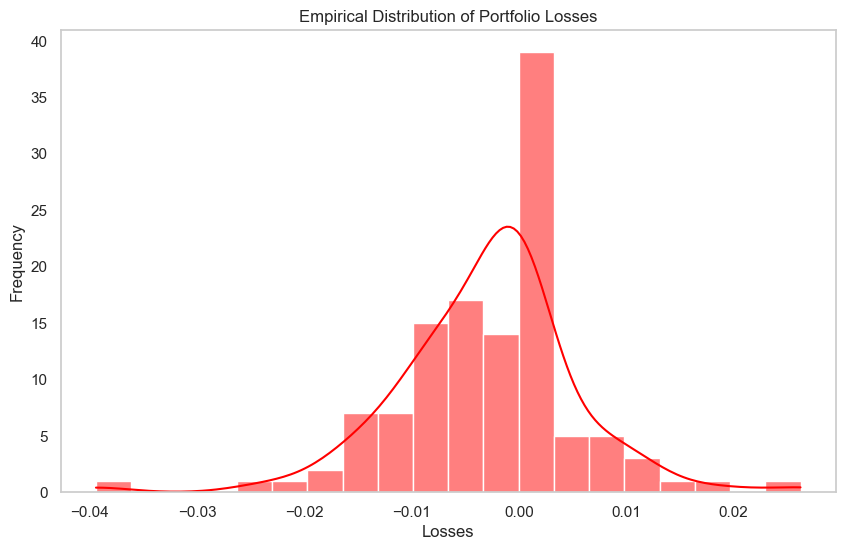

Value at Risk (VaR) at 99% confidence level: -0.05


In [8]:
#Calculate VAR for Weekly portfolio
sns.set(style="whitegrid")
Losses=-np.diff(prices_pred_kalman[0.404])
# Plotting the histogram with a kernel density estimate
plt.figure(figsize=(10, 6))
sns.histplot(Losses, bins=20, kde=True, color='red')
plt.title('Empirical Distribution of Portfolio Losses')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.grid(None)
plt.show()
VaR_99 = np.percentile(Losses, 1)*2  # since losses are negative, the 5th percentile corresponds to the 95th from a loss perspective
print("Value at Risk (VaR) at 99% confidence level: {:.2f}".format(VaR_99))

The 1M VaR at 99% confidence is equal to 5% of the invested capital, well below the MIFID.

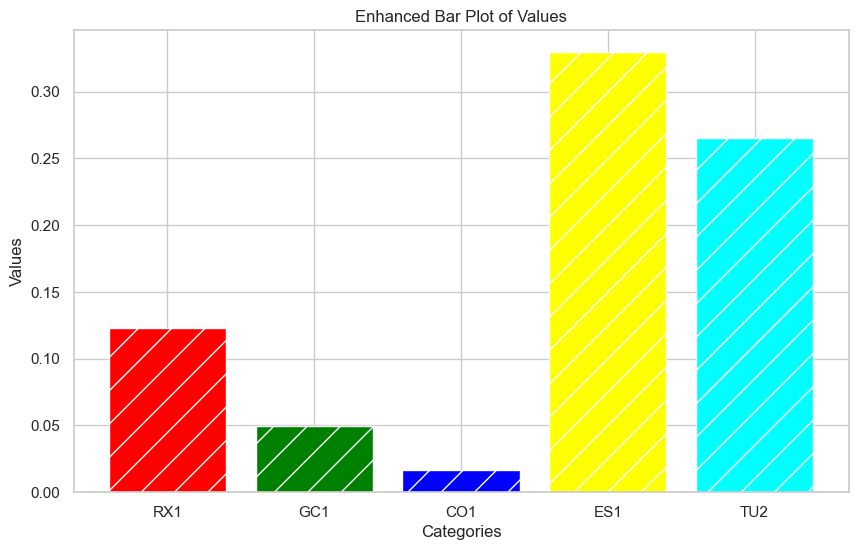

In [9]:
values=np.mean(np.abs(new_portfolio_weights),axis=0)
plt.figure(figsize=(10, 6))
plt.bar(range(len(values)),values, color=['red', 'green', 'blue', 'yellow', 'cyan'], hatch='/')
plt.title('Enhanced Bar Plot of Values')
plt.xlabel('Categories')
plt.xticks(range(len(values)), features) 
plt.ylabel('Values')
plt.grid(True)
plt.show()

We mainly invest in the S&P500 future, 2y US T-Note and 10y Bund, this asset allocation is very different from the weekly Lasso Regression and more similar to the monthly.  

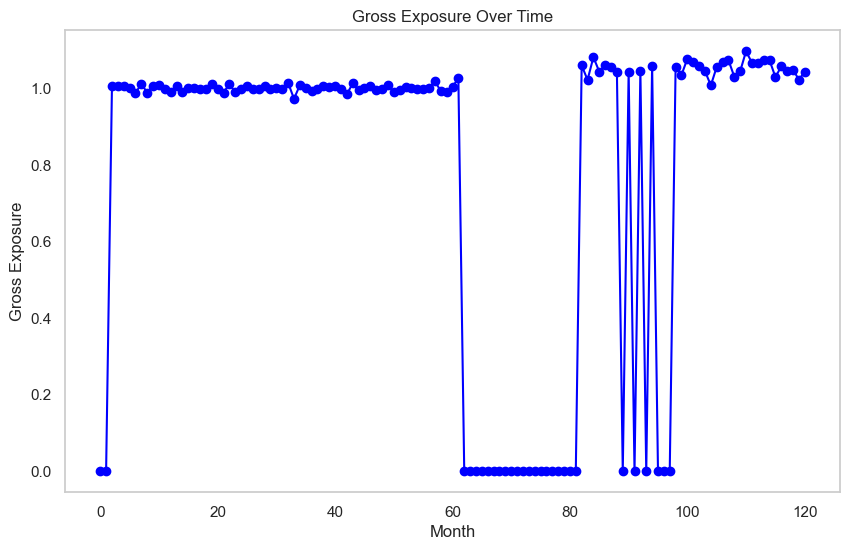

In [10]:
plt.figure(figsize=(10, 6))
values=np.sum(np.abs(new_portfolio_weights),axis=1)
plt.plot(values,marker='o', linestyle='-', color='blue')
# Adding title and labels
plt.title('Gross Exposure Over Time')
plt.xlabel('Month')
plt.ylabel('Gross Exposure')
plt.grid(None)

We see abrupt changes in the leverage, we expect it since we are using the Kalman filter and an anomalies detection system and both causes sudden variation in the asset allocation.
It's worth noticing that using alpha = 0 causes an extended period completely out of the market, obviously this isn't possible in a real life situation, and we will only use this case as a baseline for comparison with different values of alpha.

Case 2: alpha = 0.5

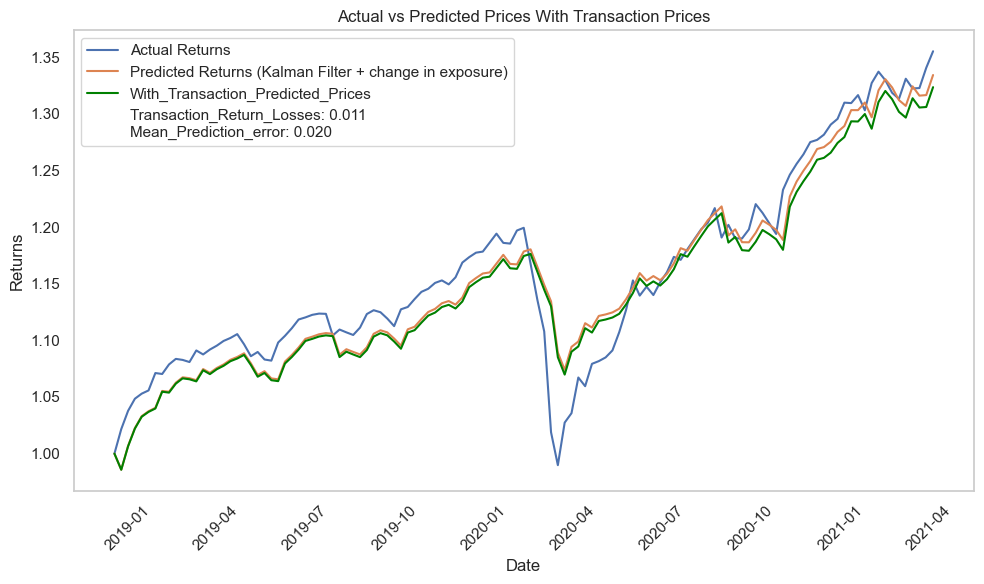

In [11]:
# Initialized vectors
y_test_kalman = []
y_pred_kalman = []
dates_plot_kalman = []

# Define parameters for Kalman filter
num_features = X.shape[1]
num_time_steps = len(y)

A = np.eye(num_features)
B = np.diag(np.diag(np.cov(X.T)))
C = np.eye(num_features)  # Inizializzazione di C(t)
D = np.std(y)

Q = np.cov(X, rowvar=False)
R = D**2

window_size = 104

portfolio_weights=[]
adjusted_portfolio_prices=[]

# Apply rolling window with Kalman filter
for i in range(window_size, len(returns) - 1):
    # Split the data into training and testing sets using rolling window
    X_train = X[i-window_size:i]
    y_train = y[i-window_size:i]
    X_test = X[i:i+1]  # Test set contains one sample from the next time step
    
    # Initialize state estimate and covariance for the window
    x_estimate = np.zeros(num_features)
    P_estimate = np.eye(num_features)
    
    # Kalman filter loop for training set
    for t in range(window_size):
        # Predict
        x_estimate = np.dot(A, x_estimate) + np.dot(B, np.random.randn(num_features))
        P_estimate = np.dot(np.dot(A, P_estimate), A.T) + Q

        # Update
        C = X_train[t].reshape(1, -1)
        K = np.dot(np.dot(P_estimate, C.T), np.linalg.inv(np.dot(np.dot(C, P_estimate), C.T) + R))
        residual = y_train[t] - np.dot(C, x_estimate)
        x_estimate = x_estimate + np.dot(K, residual)
        P_estimate = np.dot((np.eye(num_features) - np.dot(K, C)), P_estimate)
    
    # Prediction step for the test instance
    C = X_test
    x_estimate = np.dot(A, x_estimate) + np.dot(B, np.random.randn(num_features))
    P_estimate = np.dot(np.dot(A, P_estimate), A.T) + Q
    K = np.dot(np.dot(P_estimate, C.T), np.linalg.inv(np.dot(np.dot(C, P_estimate), C.T) + R))
    residual = y_train[-1] - np.dot(C, x_estimate)
    x_estimate = x_estimate + np.dot(K, residual)
    P_estimate = np.dot((np.eye(num_features) - np.dot(K, C)), P_estimate)
    
    portfolio_weights.append(x_estimate)
    # Store the results
    # print("ptf weights: ", x_estimate)
    # print()
    y_test_kalman.append(y[i])
    y_pred_kalman.append(np.dot(C, x_estimate))  # Only extract the prediction for the single test instance
    dates_plot_kalman.append(dates[i])

x_estimate_new={}
y_pred_kalman_new = {}
alpha = 0.5
new_portfolio_weights=[];
for key in keys:
    x_estimate_new[key] = portfolio_weights.copy()  
    flat_list = [item[0] for item in y_pred_kalman] 
    y_pred_kalman_new[key] = flat_list

for key in keys:
    anomalie = [i for i, valore in enumerate(result[key]) if valore == 1]
    anomalie = [x - window_size for x in anomalie]
    for i in range(len(y_pred_kalman)):
        new_portfolio_weights.append(portfolio_weights[i]);
        if i in anomalie:
            new_portfolio_weights[-1]*=alpha;
            x_estimate_new[key][i] = x_estimate_new[key][i]*alpha
            y_pred_kalman_new[key][i] = y_pred_kalman_new[key][i]*alpha + (1-alpha)      

#rmse_kalman = np.sqrt(mean_squared_error(y_test_kalman, y_pred_kalman))
#mae_kalman = mean_absolute_error(y_test_kalman, y_pred_kalman)

adjusted_portfolio_prices = {}
for key in keys:
    weight_changes = abs(np.diff(x_estimate_new[key], axis=0))
    cost_per_unit = 0.0005  # example cost
    adjusted_portfolio_prices[key] = [1]
    for i in range(len(weight_changes)):
        transaction_cost = calculate_transaction_costs(weight_changes[i], cost_per_unit)
        # Adjust the portfolio price by subtracting the transaction costs
        adjusted_price = adjusted_portfolio_prices[key][-1] * (y_pred_kalman_new[key][i+1]) - transaction_cost
        adjusted_portfolio_prices[key].append(adjusted_price)

prices_test_kalman = ret2price(np.array(y_test_kalman))

prices_pred_kalman = {}
for key in keys:
    prices_pred_kalman[key] = ret2price(np.array(y_pred_kalman_new[key]))

performance = {}
for key in keys:
    performance[key] = sum(prices_pred_kalman[key]-prices_test_kalman)

best_key = max(performance, key=performance.get)
    
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(dates_plot_kalman, prices_test_kalman, label='Actual Returns')
plt.plot(dates_plot_kalman, prices_pred_kalman[0.404], label='Predicted Returns (Kalman Filter + change in exposure)')
plt.plot(dates_plot_kalman , adjusted_portfolio_prices[0.404], label='With_Transaction_Predicted_Prices', color='Green')
plt.xlabel('Date')
plt.ylabel('Returns')

Transaction_losses=prices_pred_kalman[0.404][-1]-adjusted_portfolio_prices[0.404][-1]

Mean_Prediction_error=np.mean(np.abs(prices_pred_kalman[0.404]-prices_test_kalman))

extra_legend_labels = [
    f'Transaction_Return_Losses: {Transaction_losses:.3f}\n'
    f'Mean_Prediction_error: {Mean_Prediction_error:.3f}'
    ]

# Add dummy plots for the extra legend entries
plt.plot([], [], ' ', label=extra_legend_labels[0])

#plt.title('Actual vs Predicted Returns using Kalman Filter (RMSE={:.4f})'.format(rmse_kalman))
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Actual vs Predicted Prices With Transaction Prices')
plt.tight_layout()
plt.grid(None)
plt.show()

In this case we managed to avoid the catastrophic loss of the covid crash, even if we incurred into some losses. 

We obtained a better tracking with respect to the previous case obtain a better tracking M_P_E = 0.020 vs 0.028, also we spent a bit less on transaction cost 0.011 vs 0.012. 

This choice of alpha could be selected in a real life situation and recommended to a quite conservative investor.  

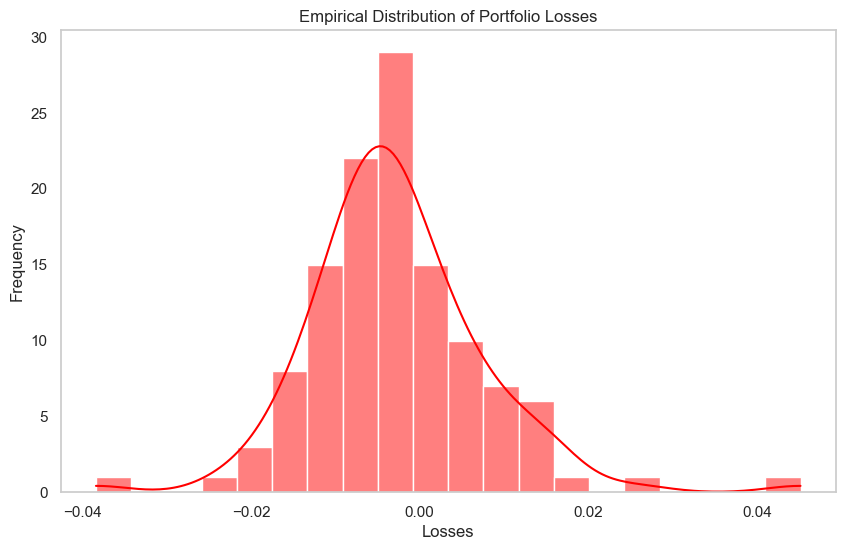

Value at Risk (VaR) at 99% confidence level: -0.05


In [12]:
#Calculate VAR for Weekly portfolio
sns.set(style="whitegrid")
Losses=-np.diff(prices_pred_kalman[0.404])
# Plotting the histogram with a kernel density estimate
plt.figure(figsize=(10, 6))
sns.histplot(Losses, bins=20, kde=True, color='red')
plt.title('Empirical Distribution of Portfolio Losses')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.grid()
plt.show(None)
VaR_99 = np.percentile(Losses, 1)*2  # since losses are negative, the 5th percentile corresponds to the 95th from a loss perspective
print("Value at Risk (VaR) at 99% confidence level: {:.2f}".format(VaR_99))

The VaR is the same as the previous case, but here we have a smoother distribution. 

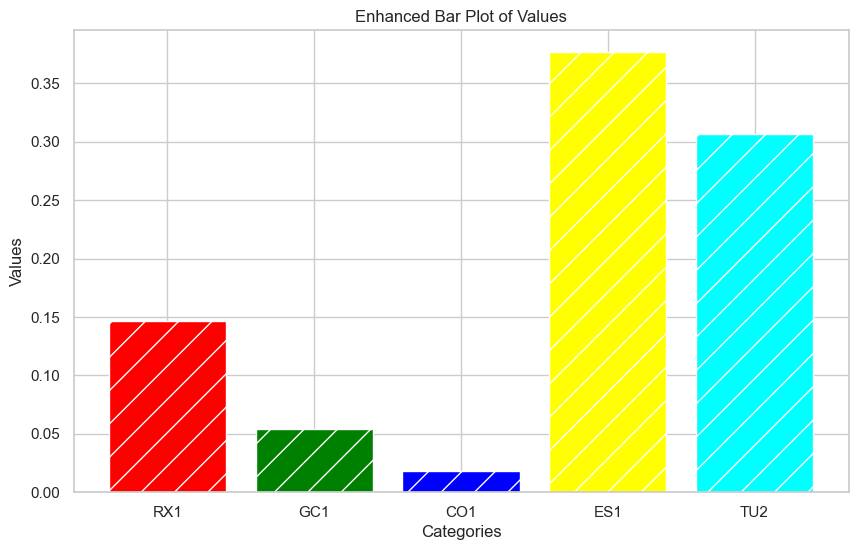

In [13]:
values=np.mean(np.abs(new_portfolio_weights),axis=0)
plt.figure(figsize=(10, 6))
plt.bar(range(len(values)),values, color=['red', 'green', 'blue', 'yellow', 'cyan'], hatch='/')
plt.title('Enhanced Bar Plot of Values')
plt.xlabel('Categories')
plt.xticks(range(len(values)), features) 
plt.ylabel('Values')
plt.grid(True)
plt.show()

We are changing the asset allocation increasing our exposure on short term US bond futures and on 10y Bund futures, with respect to the previous case.

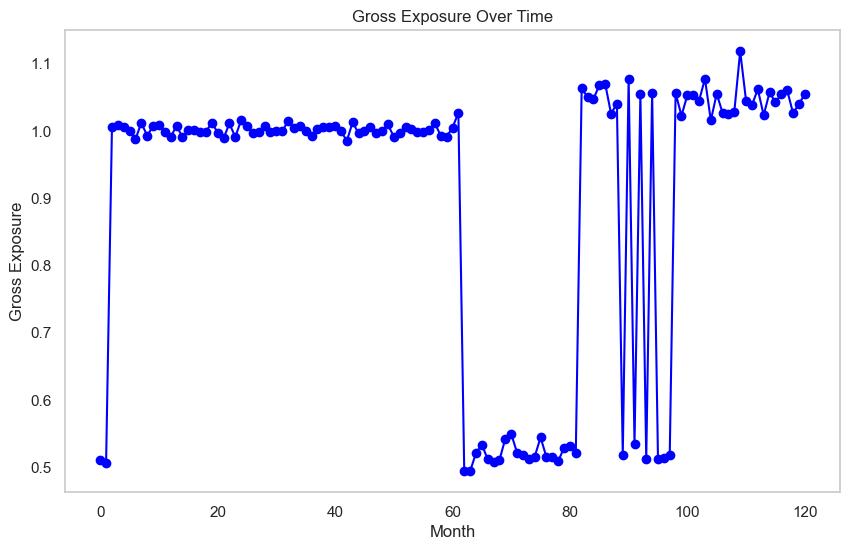

In [14]:
plt.figure(figsize=(10, 6))
values=np.sum(np.abs(new_portfolio_weights),axis=1)
plt.plot(values,marker='o', linestyle='-', color='blue')
# Adding title and labels
plt.title('Gross Exposure Over Time')
plt.xlabel('Month')
plt.ylabel('Gross Exposure')
plt.grid(None)

As in the previous case we have sudden changes in the exposure, but here at most we decrease it at one half, this is by far a more realistic situation and in period of intense stress in the market staying in cash can be preferable.

Case 3: alpha=0.8

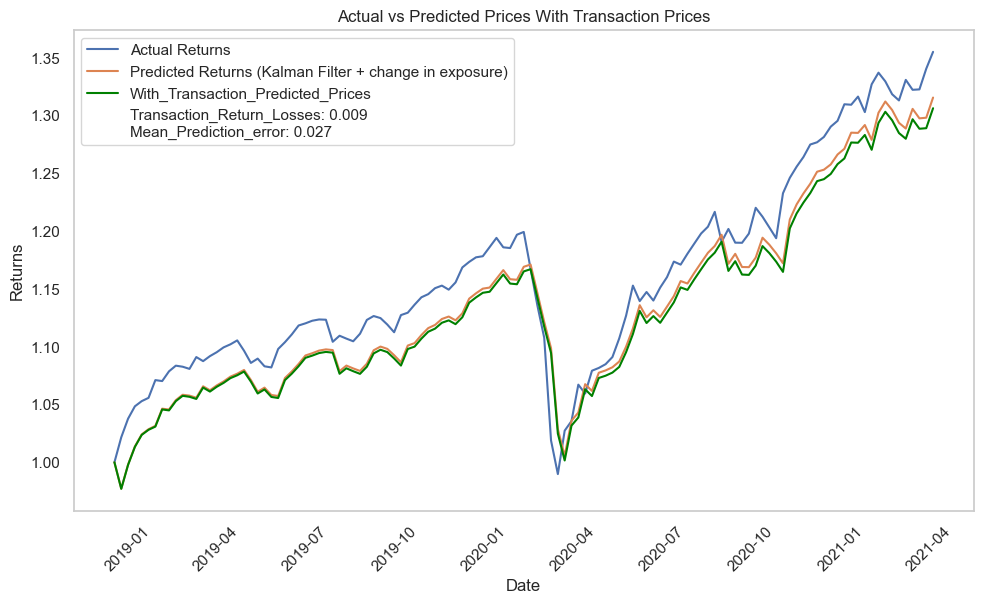

In [15]:
# Initialized vectors
y_test_kalman = []
y_pred_kalman = []
dates_plot_kalman = []

# Define parameters for Kalman filter
num_features = X.shape[1]
num_time_steps = len(y)

A = np.eye(num_features)
B = np.diag(np.diag(np.cov(X.T)))
C = np.eye(num_features)  # Inizializzazione di C(t)
D = np.std(y)

Q = np.cov(X, rowvar=False)
R = D**2

window_size = 104

portfolio_weights=[]
adjusted_portfolio_prices=[]

# Apply rolling window with Kalman filter
for i in range(window_size, len(returns) - 1):
    # Split the data into training and testing sets using rolling window
    X_train = X[i-window_size:i]
    y_train = y[i-window_size:i]
    X_test = X[i:i+1]  # Test set contains one sample from the next time step
    
    # Initialize state estimate and covariance for the window
    x_estimate = np.zeros(num_features)
    P_estimate = np.eye(num_features)
    
    # Kalman filter loop for training set
    for t in range(window_size):
        # Predict
        x_estimate = np.dot(A, x_estimate) + np.dot(B, np.random.randn(num_features))
        P_estimate = np.dot(np.dot(A, P_estimate), A.T) + Q

        # Update
        C = X_train[t].reshape(1, -1)
        K = np.dot(np.dot(P_estimate, C.T), np.linalg.inv(np.dot(np.dot(C, P_estimate), C.T) + R))
        residual = y_train[t] - np.dot(C, x_estimate)
        x_estimate = x_estimate + np.dot(K, residual)
        P_estimate = np.dot((np.eye(num_features) - np.dot(K, C)), P_estimate)
    
    # Prediction step for the test instance
    C = X_test
    x_estimate = np.dot(A, x_estimate) + np.dot(B, np.random.randn(num_features))
    P_estimate = np.dot(np.dot(A, P_estimate), A.T) + Q
    K = np.dot(np.dot(P_estimate, C.T), np.linalg.inv(np.dot(np.dot(C, P_estimate), C.T) + R))
    residual = y_train[-1] - np.dot(C, x_estimate)
    x_estimate = x_estimate + np.dot(K, residual)
    P_estimate = np.dot((np.eye(num_features) - np.dot(K, C)), P_estimate)
    
    portfolio_weights.append(x_estimate)
    # Store the results
    # print("ptf weights: ", x_estimate)
    # print()
    y_test_kalman.append(y[i])
    y_pred_kalman.append(np.dot(C, x_estimate))  # Only extract the prediction for the single test instance
    dates_plot_kalman.append(dates[i])

x_estimate_new={}
y_pred_kalman_new = {}
alpha = 0.8
new_portfolio_weights=[];
for key in keys:
    x_estimate_new[key] = portfolio_weights.copy()  
    flat_list = [item[0] for item in y_pred_kalman] 
    y_pred_kalman_new[key] = flat_list

for key in keys:
    anomalie = [i for i, valore in enumerate(result[key]) if valore == 1]
    anomalie = [x - window_size for x in anomalie]
    for i in range(len(y_pred_kalman)):
        new_portfolio_weights.append(portfolio_weights[i]);
        if i in anomalie:
            new_portfolio_weights[-1]*=alpha;
            x_estimate_new[key][i] = x_estimate_new[key][i]*alpha
            y_pred_kalman_new[key][i] = y_pred_kalman_new[key][i]*alpha + (1-alpha)
            
#rmse_kalman = np.sqrt(mean_squared_error(y_test_kalman, y_pred_kalman))
#mae_kalman = mean_absolute_error(y_test_kalman, y_pred_kalman)

adjusted_portfolio_prices = {}
for key in keys:
    weight_changes = abs(np.diff(x_estimate_new[key], axis=0))
    cost_per_unit = 0.0005  # example cost
    adjusted_portfolio_prices[key] = [1]
    for i in range(len(weight_changes)):
        transaction_cost = calculate_transaction_costs(weight_changes[i], cost_per_unit)
        # Adjust the portfolio price by subtracting the transaction costs
        adjusted_price = adjusted_portfolio_prices[key][-1] * (y_pred_kalman_new[key][i+1]) - transaction_cost
        adjusted_portfolio_prices[key].append(adjusted_price)

prices_test_kalman = ret2price(np.array(y_test_kalman))

prices_pred_kalman = {}
for key in keys:
    prices_pred_kalman[key] = ret2price(np.array(y_pred_kalman_new[key]))

performance = {}
for key in keys:
    performance[key] = sum(prices_pred_kalman[key]-prices_test_kalman)

best_key = max(performance, key=performance.get)
    
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(dates_plot_kalman, prices_test_kalman, label='Actual Returns')
plt.plot(dates_plot_kalman, prices_pred_kalman[0.404], label='Predicted Returns (Kalman Filter + change in exposure)')
plt.plot(dates_plot_kalman , adjusted_portfolio_prices[0.404], label='With_Transaction_Predicted_Prices', color='Green')
plt.xlabel('Date')
plt.ylabel('Returns')
#plt.title('Actual vs Predicted Returns using Kalman Filter (RMSE={:.4f})'.format(rmse_kalman))

Transaction_losses=prices_pred_kalman[0.404][-1]-adjusted_portfolio_prices[0.404][-1]

Mean_Prediction_error=np.mean(np.abs(prices_pred_kalman[0.404]-prices_test_kalman))

extra_legend_labels = [
    f'Transaction_Return_Losses: {Transaction_losses:.3f}\n'
    f'Mean_Prediction_error: {Mean_Prediction_error:.3f}'
    ]

# Add dummy plots for the extra legend entries
plt.plot([], [], ' ', label=extra_legend_labels[0])

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Actual vs Predicted Prices With Transaction Prices')
plt.grid(None)
plt.show()

In this case we don't avoid the covid crash, but at least we rebound as quickly as the index, avoiding the terrible error of staying out of the market during the bullish trend after the bottom.

We tracked worse than the previous case M_P_E = 0.027 vs 0.020 and we payed a bit less on transaction cost = 0.008 vs 0.011. 

Overall this case tracks worst and incurs in bigger losses than the previous one and should not be proposed to an investor. 

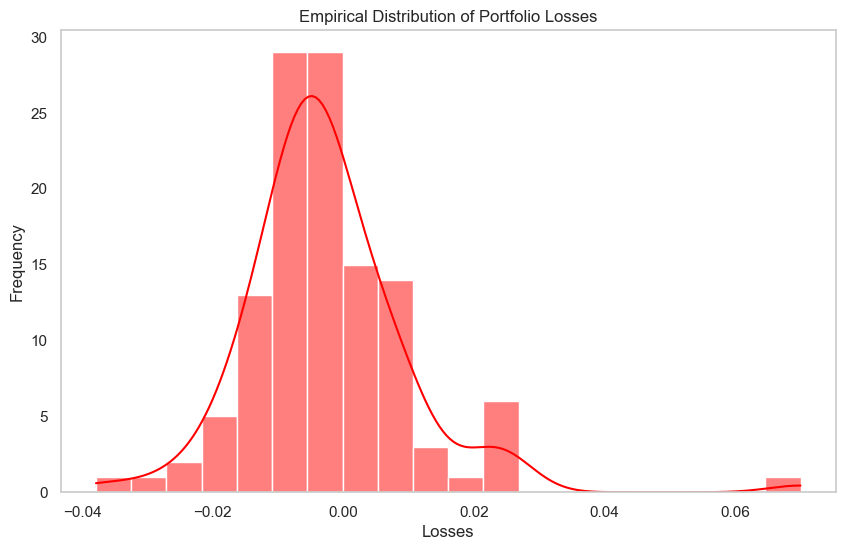

Value at Risk (VaR) at 99% confidence level: -0.06


In [16]:
#Calculate VAR for Weekly portfolio
sns.set(style="whitegrid")
Losses=-np.diff(prices_pred_kalman[0.404])
# Plotting the histogram with a kernel density estimate
plt.figure(figsize=(10, 6))
sns.histplot(Losses, bins=20, kde=True, color='red')
plt.title('Empirical Distribution of Portfolio Losses')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.grid(None)
plt.show()
VaR_99 = np.percentile(Losses, 1)*2  # since losses are negative, the 5th percentile corresponds to the 95th from a loss perspective
print("Value at Risk (VaR) at 99% confidence level: {:.2f}".format(VaR_99))

The VaR is 20% higher than first two cases, this is consistent with a more aggressive alpha, but still under MIFID regulation.

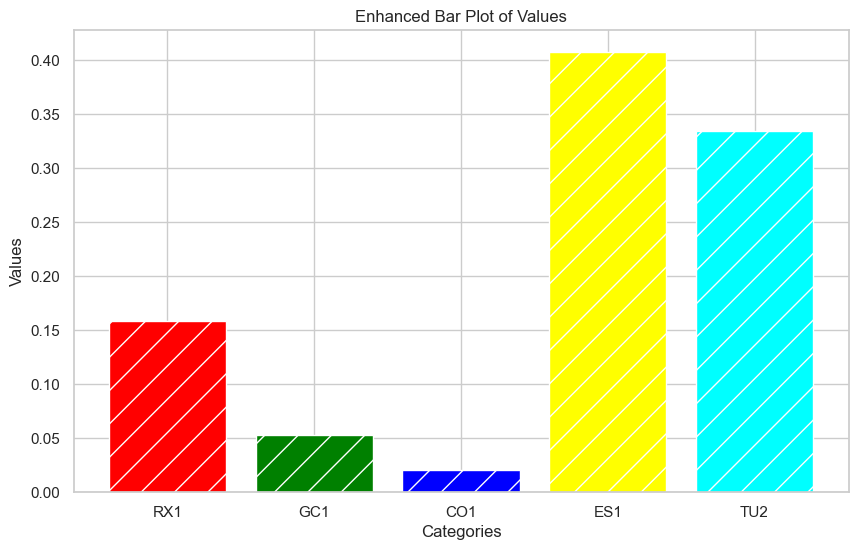

In [17]:
values=np.mean(np.abs(new_portfolio_weights),axis=0)
plt.figure(figsize=(10, 6))
plt.bar(range(len(values)),values, color=['red', 'green', 'blue', 'yellow', 'cyan'], hatch='/')
plt.title('Enhanced Bar Plot of Values')
plt.xlabel('Categories')
plt.xticks(range(len(values)), features) 
plt.ylabel('Values')
plt.grid(True)
plt.show()

The asset allocation is now more exposed to equity, in particular S&P500 future, this is in line with a more aggressive strategy imposed by the higher alpha. 
We have also increased our overall exposition on bond futures.

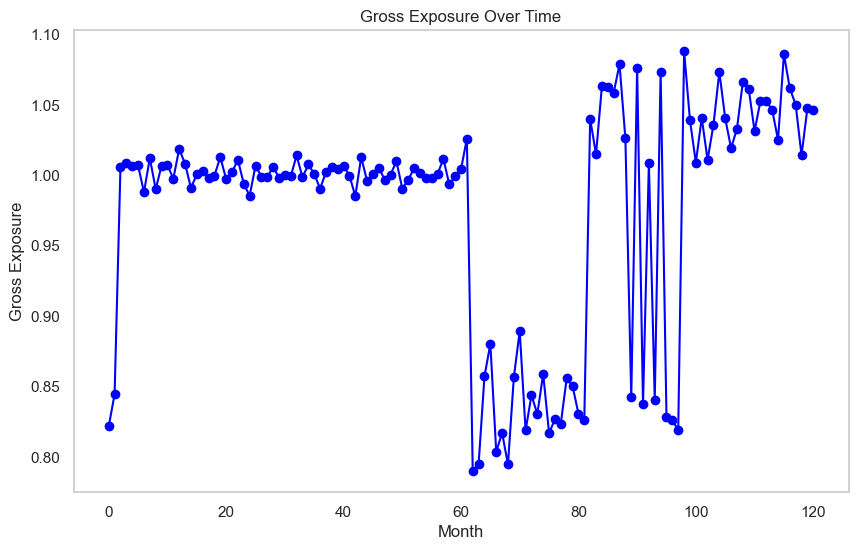

In [18]:
plt.figure(figsize=(10, 6))
values=np.sum(np.abs(new_portfolio_weights),axis=1)
plt.plot(values,marker='o', linestyle='-', color='blue')
# Adding title and labels
plt.title('Gross Exposure Over Time')
plt.xlabel('Month')
plt.ylabel('Gross Exposure')
plt.grid(None)

The leverage trend is very similar to previous cases, but we can notice that the variation on the whole period are more noisy. During the period of month 60-80 where we are in a risk-off situation we tend to sometimes increase our exposure to quickly capitalized on short bullish replacements, consistent with an aggressive approach. Also here at most we decrease our leverage at 0.80 accordingly to the alpha chosen. 